In [1]:
"""
This file makes calls to functions in the michael_morris_github_code folder.
"""

import sys
sys.path.append("./../common/")
from utils import *
sys.path.append("./../michael_morris_github_code/")
from NNs import *
from DataConstructor import *

figures_dir = "../../dump/"
filename = 'generated_sine_masked'

10


In [2]:
# optimised hyperparameters
optimised = {'epochs': 265.6150669873715, 'kl_power': -3.710321342869496, 'lr_power': -2.847009864108607, 'op_scale': 0.07284723629769228, 'prior_scale': 0.09943329579263478, 'q_scale': 0.05294656811275324, 'rnn_units': 49.93817992108936}

irnn_type = FIB_RNN
batch_size=32

if irnn_type.loss == "EDL":
    optimised["kl_power"] = None
    optimised["op_scale"] = None
    optimised["prior_scale"] = None
    optimised["q_scale"] = None
else:
    optimised['edl_coeff'] = None

gammas = [7,14,21,28]
test_seasons = [2015,2016,2017,2018]
models = {}

for gamma in gammas:
    _data = DataConstructor(gamma=gamma)
    x_train, y_train, x_test, y_test = _data('generated', filename=filename)
    irnns = FI_NNs(rnn_units=optimised['rnn_units'], kl_power=optimised['kl_power'], op_scale=optimised['op_scale'], prior_scale=optimised['prior_scale'], q_scale=optimised['q_scale'], gamma=gamma, lr_power=optimised['lr_power'], n_batches=int(len(y_train)/batch_size), irnn_type=irnn_type, edl_coeff=optimised['edl_coeff'])
    history = irnns.train(x_train, y_train, epochs=int(optimised['epochs']), verbose=False)
    print(history)

    models[str(gamma)] = irnns

2023-03-19 21:09:44.400380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[-1.3641529083251953, -1.56227707862854, -1.5956647396087646, -1.452042579650879, -1.3169573545455933, -1.4234706163406372, -1.4081460237503052, -1.3994907140731812, -1.5274810791015625, -1.5421165227890015]
[-1.0258902311325073, -1.1158262491226196, -1.0827414989471436, -1.0526055097579956, -1.0549802780151367, -0.957834005355835, -1.0575332641601562, -0.9522090554237366, -0.7223062515258789, -1.1489776372909546]
[-0.7962427735328674, -1.0144420862197876, -0.891706109046936, -0.9320703148841858, -1.038300633430481, -0.8525930047035217, -0.7908264398574829, -0.8054087162017822, -0.758928656578064, -0.6781182885169983]
[-0.6183059811592102, -0.7700866460800171, -0.6921377778053284, -0.31991657614707947, -0.8712766766548157, -0.9532385468482971, -0.4026241600513458, -0.47225773334503174, -0.6131690144538879, -0.786150336265564]


7
7 2015
LEN 10
7  diffs  [0.0065180096]
7  diffs  [0.005183978]
7  diffs  [0.0069587813]
7  diffs  [0.007999365]
7  diffs  [0.006582346]
7  diffs  [0.0075082574]
7  diffs  [0.004853258]
7  diffs  [0.009317767]
7  diffs  [0.005323981]
7  diffs  [0.0073009063]
7 2016
LEN 10
7  diffs  [0.0053762305]
7  diffs  [0.005715956]
7  diffs  [0.008180487]
7  diffs  [0.0068840394]
7  diffs  [0.008372134]
7  diffs  [0.0072469776]
7  diffs  [0.005774008]
7  diffs  [0.0056651453]
7  diffs  [0.00647582]
7  diffs  [0.007254593]
7 2017
LEN 10
7  diffs  [0.0058806953]
7  diffs  [0.0065716766]
7  diffs  [0.005965523]
7  diffs  [0.007589871]
7  diffs  [0.0063773766]
7  diffs  [0.006921575]
7  diffs  [0.0070448574]
7  diffs  [0.005163345]
7  diffs  [0.0059192316]
7  diffs  [0.0052010035]
7 2018
LEN 10
7  diffs  [0.0066465014]
7  diffs  [0.0054843356]
7  diffs  [0.0060528987]
7  diffs  [0.0055780723]
7  diffs  [0.0068494896]
7  diffs  [0.005655036]
7  diffs  [0.008140417]
7  diffs  [0.007898389]
7  diffs  [0

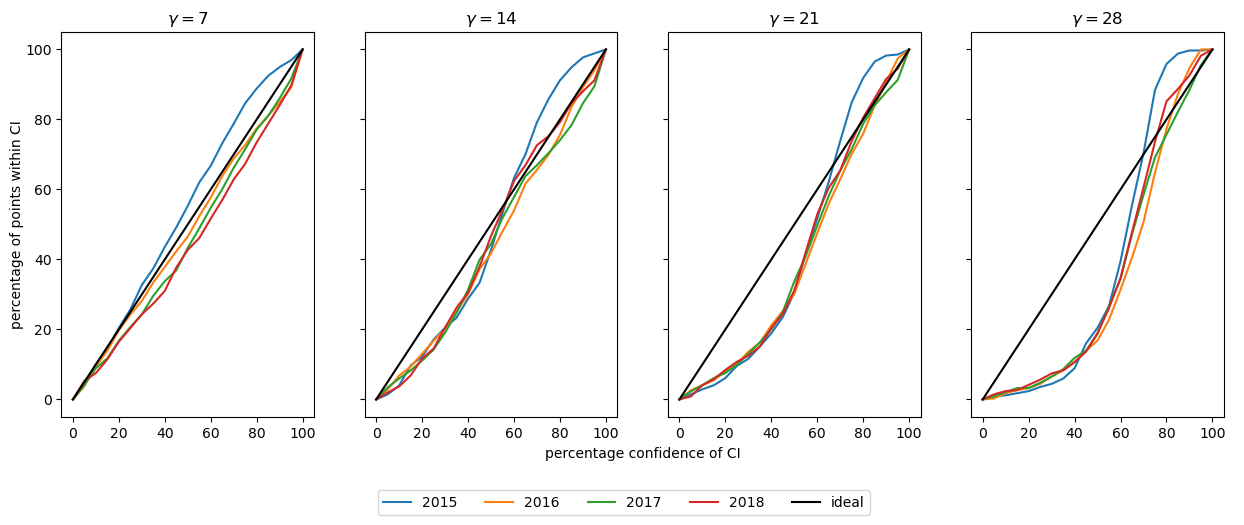

In [3]:
def gamma_data(array, gamma):
    if type(array) != type(np.array([])):
        array = array._numpy()
    return array.flatten()[:len(array)-gamma]

fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0

calibrations = {}
predictions = {}
Y_HAT, SD_HAT, MODEL_UNC, DATA_UNC = 0, 1, 2, 3
for gamma, model in models.items():
    calibrations[gamma] = {}
    predictions[gamma] = {}

confidences = get_confidence_axis()
for gamma, model in models.items():
    print(gamma)
    gamma_str = gamma
    gamma = int(gamma)

    for season in test_seasons:
        print(gamma, season)
        season_str = str(season)
        _data = DataConstructor(test_season=season, gamma=gamma)
        _, _, x_test, y_test = _data('generated', filename=filename)
        predictions[gamma_str][season_str] = model.get_predictions(x_test, stable=True)
        in_range = unc_calibration(gamma_data(y_test[:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][Y_HAT][:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][SD_HAT][:,-1:,:], gamma))
        try:
            axs[idx].plot(confidences, in_range, label=str(season))
        except:
            print('in except')
            axs[idx].plot(confidences, in_range[1], label=str(season))
        calibrations[gamma_str][season_str] = in_range

    axs[idx].plot([0,100], [0,100], label="ideal", c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', test_seasons + ['ideal'])


In [6]:
# graphs on
test_year = 2015
test_gamma = 28
test_gamma_str = str(test_gamma)
test_year_str = str(test_year)

In [14]:
# UNNORMALISING
test_years = ['2015','2016','2017','2018']
for year in test_years:
    for gamma in gammas:
        _data = DataConstructor(gamma=gamma, test_season=int(year))
        _, _, _, y_test = _data('generated', filename=filename)
        y_test = y_test._numpy()
        for i in range(gamma):
            y_hat = predictions[str(gamma)][year][Y_HAT][:,i,:].flatten()
            predictions[str(gamma)][year][Y_HAT][:,i,:] = rescale_array('y', y_hat, _data.scaler)
            predictions[str(gamma)][year][SD_HAT][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][SD_HAT][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][DATA_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][DATA_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][MODEL_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][MODEL_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)

(365, 7, 1)
(365, 14, 1)
(365, 21, 1)
(365, 28, 1)


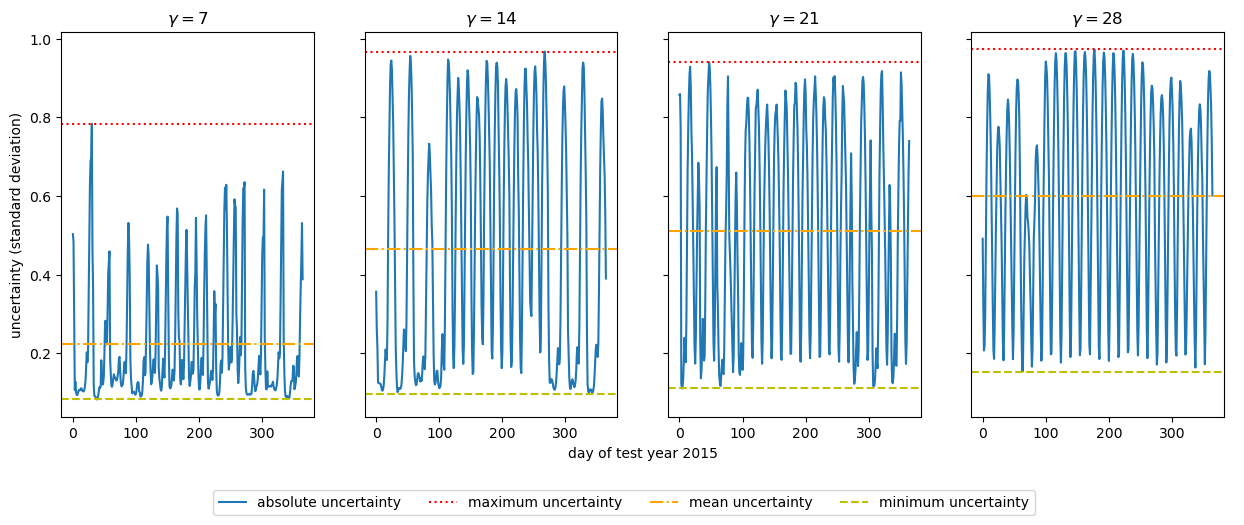

In [27]:
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0
days = np.arange(0,365)
for gamma, prediction in predictions.items():

    print(prediction[test_year_str][SD_HAT].shape)

    sds = prediction[test_year_str][SD_HAT][:,-1:,:].flatten()
    axs[idx].plot(sds)
    axs[idx].axhline(y = np.max(sds), color = 'r', linestyle = ':', label='maximum uncertainty')
    axs[idx].axhline(y = np.mean(sds), color = 'orange', linestyle = '-.', label='mean uncertainty')
    axs[idx].axhline(y = np.min(sds), color = 'y', linestyle = '--', label='minimum uncertainty')
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'day of test year {}'.format(test_year_str), 'uncertainty (standard deviation)', figures_dir, 'test.png', ['absolute uncertainty', 'maximum uncertainty', 'mean uncertainty', 'minimum uncertainty'])